In this notbook, 100 stocks belong to S&P 500 index will be compared based on their option returns, volitility and trading volume and reasons for choosing TESLA among them will be explained.

In [1]:
import yfinance as yf
import pandas as pd    
import numpy as np     
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
import warnings
import plotly.graph_objects as go
import requests

In [2]:
start_date = datetime.fromisoformat("2021-04-15")
end_date = datetime.fromisoformat("2022-04-16")
market_cal = pd.read_pickle('market_calendar')

In [ ]:
# import s&p500 top 100 volatile tickers
with open("ticker_list", "rb") as fp:
    ticker_list = pickle.load(fp)

# filter out thickers with monthly option expiry
tickers_weekly_option = []
for ticker in ticker_list:
    tick = yf.Ticker(ticker)
    df = tick.history(period='1d', progress=False)
    exp_list = tick.options
    
    if df['Close'][0]>100 and len(list(filter(lambda x: '2022-05' in x, exp_list)))==4:
        tickers_weekly_option.append(ticker)
tickers_weekly_option = np.array(tickers_weekly_option)

In [25]:
# find the beginning and end of each week during the 1yr period
def allmondays(start_date, end_date):
    mondays = pd.date_range(start=str(start_date.year), end=str(end_date.year+1), freq='W-MON') 
    mondays = mondays[np.logical_and(mondays>=start_date, mondays<=end_date)]
    return mondays
mondays = allmondays(start_date, end_date)
st_dates = []
for mon in mondays:
    if mon in market_cal:
        st_dates.append(mon)
    else:
        st_dates.append(market_cal[market_cal>mon][0])  
st_dates = np.array(st_dates)

def allfridays(start_date, end_date):    
    fridays = pd.date_range(start=str(start_date.year), end=str(end_date.year+1), freq='W-FRI')    
    fridays = fridays[np.logical_and(fridays>=start_date, fridays<=end_date)]
    return fridays
fridays = allfridays(start_date, end_date)
exp_dates = []           
for frid in fridays:
    if frid in market_cal:
        exp_dates.append(frid) 
    else:
        exp_dates.append(market_cal[market_cal<frid][-1])   
exp_dates = np.array(exp_dates)

if st_dates[-1] > exp_dates[-1]:
    st_dates = np.delete(st_dates, -1)
if st_dates[0] > exp_dates[0]:
    exp_dates = np.delete(exp_dates, 0)

Polygon api is used below to get historical options data. They are one of the few reliable platforms that provide historical end-of-day data for free.

In [654]:
def options_historical(ticker, strike, type_, exp_date, from_, to):
    key = myKey 
    ticker = ticker+exp_date+str.capitalize(type_)+f'{strike:05}'+'000'    
    url = 'https://api.polygon.io/v2/aggs/ticker/O:'+ticker+'/range/1/day/'+from_+'/'+to+'?adjusted=true&sort=asc&limit=200&apiKey='+key
    resp = requests.get(url)  
    return resp.json()

def round_base(x, base):
    return int(base * round(x/base))
    
    
def option_return(ticker, st_date, exp_date):
    #put_return, call_return = 0, 0
    volume = np.nan
    df = yf.download(ticker, start=st_date, end=st_date+timedelta(days=1), progress=False)     
    price = df['Close'][0]   

    if price > 500:
        calls = round_base(1.2*price, 10)
        calll = round_base(1.25*price, 10)
        puts = round_base(.8*price, 10)
        putl = round_base(.75*price, 10)
    else:
        calls = round_base(1.2*price, 5)
        calll = round_base(1.25*price, 5)
        puts = round_base(.8*price, 5)
        putl = round_base(.75*price, 5)
        
                
    resp = options_historical(ticker, calls, 'c', exp_date.strftime("%y%m%d"), st_date.strftime("%Y-%m-%d"), st_date.strftime("%Y-%m-%d"))
    if 'results' in resp and resp['results'][0]['v']>10:
        volume = resp['results'][0]['v']
        call_return = resp['results'][0]['c']
    else:
        call_return = np.nan        
    resp = options_historical(ticker, calll, 'c', exp_date.strftime("%y%m%d"), st_date.strftime("%Y-%m-%d"), st_date.strftime("%Y-%m-%d"))
    if 'results' in resp and resp['results'][0]['v']>10:
        call_return = call_return - resp['results'][0]['c']
    else:
        call_return = np.nan
            
    resp = options_historical(ticker, puts, 'p', exp_date.strftime("%y%m%d"), st_date.strftime("%Y-%m-%d"), st_date.strftime("%Y-%m-%d"))
    if 'results' in resp and resp['results'][0]['v']>10:
        put_return = resp['results'][0]['c']
        volume += resp['results'][0]['v']
    else:
        put_return = np.nan      
    resp = options_historical(ticker, putl, 'p', exp_date.strftime("%y%m%d"), st_date.strftime("%Y-%m-%d"), st_date.strftime("%Y-%m-%d"))
    if 'results' in resp and resp['results'][0]['v']>10:
        put_return = put_return - resp['results'][0]['c']
    else:
        put_return = np.nan 
        
    mean_return = 100*np.nanmean([call_return/(calll-calls+1e-9), put_return/(puts-putl+1e-9)])
    return mean_return, volume/2

In [663]:
warnings.filterwarnings('ignore')
returns = np.zeros((len(tickers_weekly_option), len(st_dates))) 
volume = np.zeros((len(tickers_weekly_option), len(st_dates)))   

for i, tick in enumerate(tickers_weekly_option):
    for j in range(len(st_dates)):
        returns[i, j], volume[i, j] = option_return(tick, st_dates[j], exp_dates[j])

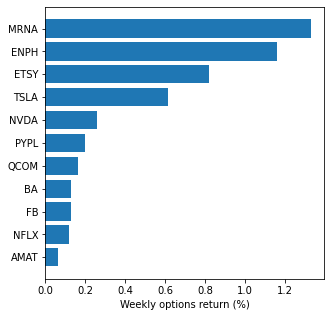

In [9]:
returns_fill = np.where(np.isnan(returns), 0, returns)
mean_return = np.nanmean(returns_fill, axis=1)
candidates_liquid = np.count_nonzero(np.isnan(returns), axis=1)<len(st_dates)/2
mean_return = mean_return[candidates_liquid]
tickers_candidate = tickers_weekly_option[candidates_liquid]
idx_sort = np.argsort(mean_return)

plt.figure(figsize=(5,5))
plt.barh(tickers_candidate[idx_sort], mean_return[idx_sort])
plt.xlabel('Weekly options return (%)')

In the chart above, return was calculated by dividing iron condor net premium by margin requirement.

In [677]:
# calculate ticker's daily return volitility over the last year
volitility = np.array([])
for tick in tickers_candidate:
    df = yf.download(tick, start=start_date, end=end_date, progress=False)
    volitility = np.append(volitility, 100*((df['Close']-df['Close'].shift(periods=1))/df['Close'].shift(periods=1)).std())

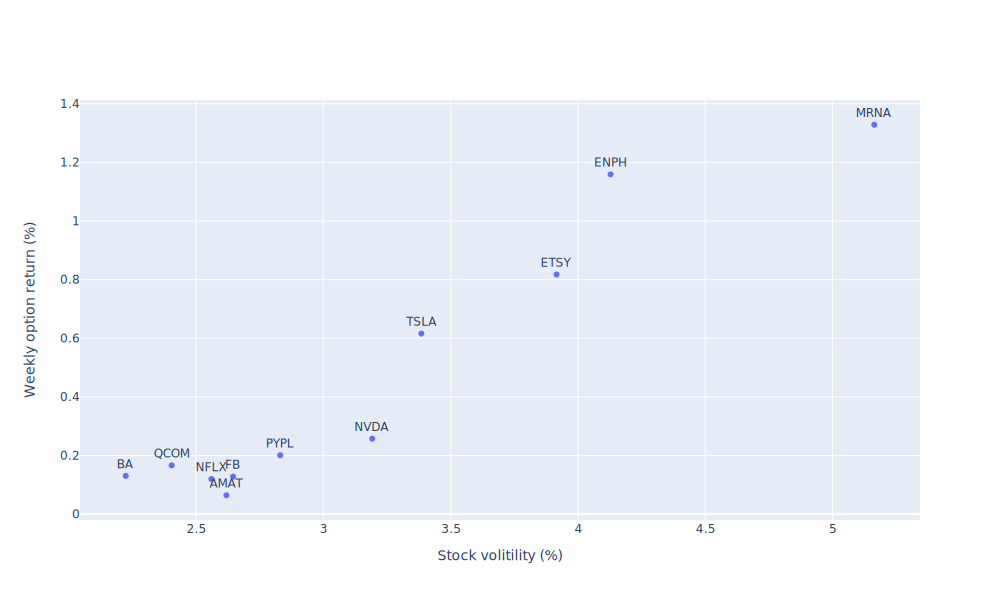

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x= volitility,
    y= mean_return,
    mode="markers+text",
    name="Lines, Markers and Text",
    text=tickers_candidate,
    textposition="top center"))
fig['layout']['yaxis']['title']='Weekly option return (%)'
fig['layout']['xaxis']['title']='Stock volitility (%)'

fig.show("svg", width=1000, height=600)

This is not a classic mean-varience graph, as calculating the real return and varience of return is time consuming; but it's good enough for comparing different stocks. Based on this graph, MRNA, ENPH, ETSY and TSLA would generate max return for the iron condor strategy. However they have the highest volitility which means there's a higher chance that this strategy results in loss. Below we calculate a paramater similar to Sharpe ratio to compare these tickers better:

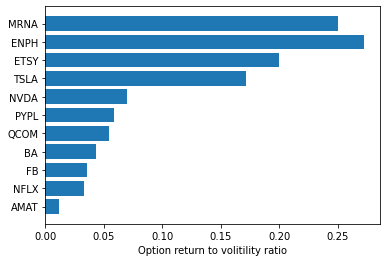

In [20]:
sharpe_ratio_psudo = (mean_return - 1.8/52)/volitility
plt.barh(tickers_candidate[idx_sort], sharpe_ratio_psudo[idx_sort])
plt.xlabel('Option return to volitility ratio');

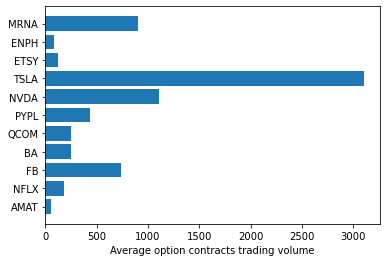

In [5]:
plt.barh(tickers_candidate[idx_sort], np.nanmean(volume,1)[idx_sort])
plt.xlabel('Average option contracts trading volume');

Based on these graphs, MRNA, ENPH, ETSY and TSLA have the highest return as well as return to volitility ratio. Therefore they are the best candidates for the designed algorithm. Because MRNA is mostly a pre-clinical stage biotech company, it is very prone to abrubt price changes following success or failure of its trials or CDC approval which make it not an ideal case for iron condor strategy.

ENPH and ETSY have around 100 contract daily trades which is barely enough for someone with significant capital to start a postion. This low volume also creates a relatively large spread between bid and ask which reduces the weekly returns. 

TSLA stands on the sweet spot where both it's return and return to volitility ratio are acceptable and it's options trading volume is high enough.